Data Source: https://tianchi.aliyun.com/dataset/649

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

In [5]:
data = pd.read_csv("C:/Users/zheji/Desktop/User Behavior Analysis/dataset/UserBehavior.csv")

In [6]:
data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']

In [7]:
data.head()

,user_id,item_id,category_id,behavior_type,timestamp
0,1,2333346,2520771,pv,1511561733
1,1,2576651,149192,pv,1511572885
2,1,3830808,4181361,pv,1511593493
3,1,4365585,2520377,pv,1511596146
4,1,4606018,2735466,pv,1511616481


In [8]:
data.isnull().sum()

user_id          0
item_id          0
category_id      0
behavior_type    0
timestamp        0
dtype: int64

In [9]:
data.describe()

,user_id,item_id,category_id,timestamp
count,1.001508e+08,1.001508e+08,1.001508e+08,1.001508e+08
mean,5.069431e+05,2.579775e+06,2.696380e+06,1.511951e+09
std,2.940605e+05,1.488056e+06,1.463155e+06,5.528006e+06
min,1.000000e+00,1.000000e+00,8.000000e+01,-2.134949e+09
25%,2.524290e+05,1.295225e+06,1.320293e+06,1.511762e+09
50%,5.040150e+05,2.580735e+06,2.671397e+06,1.511965e+09
75%,7.609490e+05,3.862042e+06,4.145813e+06,1.512179e+09
max,1.018011e+06,5.163070e+06,5.162429e+06,2.122867e+09


Note that the minimum timestamp is -2,134,949,000, which converts to approximately 1902/05/18 Beijing Time. The maximum is 2,122,867,000, which is approximately 2027/03/14 Beijing Time. The dataset description states the range is from 2017/11/25 to 2017/12/03. We will exclude data outside this range.

In [10]:
data['behavior_type'].value_counts()

behavior_type
pv      89716263
cart     5530446
fav      2888258
buy      2015839
Name: count, dtype: int64

behavior_type Explanation: 

**pv** - Page view of the product detail page, equivalent to a user clicking to view the product.


**cart** - Adding a product to the shopping cart.


**fav** -   Favoriting a product.


**buy** -  Purchasing a product.

Connect to sqlite and create table

In [11]:
conn = sqlite3.connect('user_behavior.db')
cursor = conn.cursor()

In [12]:
cursor.execute('DROP TABLE IF EXISTS user_behavior')
cursor.execute('''
    CREATE TABLE user_behavior (
    user_id INTEGER,
    item_id INTEGER,
    category_id INTEGER,
    behavior_type TEXT,
    timestamp INTEGER
)
''')
conn.commit()

In [ ]:
cursor.executemany("""insert into user_behavior values (?,?,?,?,?)""", data.values.tolist())
conn.commit()

Connect to sqlite and create table：

**Question 1: Short-term User Retention Pattern Analysis**

Question: "What are the user's short-term retention patterns within a 9-day window? What is the trend for return rates on Day 1, 2, and 3?"

**Question 2: User Behavior Conversion Funnel Analysis**

Question: "What is the conversion rate at each stage from browsing to purchasing?"

**Question 3: Peak/Off-peak Conversion Efficiency Assessment**

Question: "In a 24-hour window, during which periods do peak and valley traffic occur? How does the PV to Buy CR change from peak to valley?"

**Question 4: RFM Key User Analysis**

Question: "What are the user profiles?"

**Question 5: Product Category Performance Analysis**

Business Question: "Which product categories have the highest user engagement and repurchase rates? How should product recommendation strategies be optimized?"

# Question 1

In [ ]:
cursor.execute('DROP VIEW IF EXISTS user_behavior_data')
cursor.execute("""create view user_behavior_data as
               select 
               user_id, item_id, category_id, behavior_type,
               datetime(timestamp, 'unixepoch', '+8 hours') as activity_time -- 将unix时间戳转换为北京时间
               from user_behavior
               where datetime(timestamp, 'unixepoch', '+8 hours') BETWEEN '2017-11-25 00:00:00' AND '2017-12-03 23:59:59'""")

In [ ]:
filtered_check = """
SELECT 
    COUNT(*) as total_records,
    MIN(activity_time) as min_time,
    MAX(activity_time) as max_time,
    COUNT(DISTINCT user_id) as unique_users
FROM user_behavior_data
"""
filtered_stats = pd.read_sql_query(filtered_check, conn)
filtered_stats

,total_records,min_time,max_time,unique_users
0,100095230,2017-11-25 00:00:00,2017-12-03 23:59:59,987991


In [ ]:
len(data) - filtered_stats['total_records'][0]

55576

We filtered out a total of 55,576 records.

In [14]:
unfiltered_check = """ With
user_cohort as(
    Select user_id, date(min(activity_time)) as cohort_date
    from user_behavior_data
    group by user_id),
daily_activity as(
    Select ubd.user_id, DATE(ubd.activity_time) as activity_date, uc.cohort_date,
    Cast(julianday(ubd.activity_time) - julianday(uc.cohort_date) as integer) as day_difference
    From user_behavior_data ubd
    Join user_cohort uc on ubd.user_id = uc.user_id)
Select
    cohort_date, count(distinct user_id) as cohort_size, 
    round(100 * count(distinct case when day_difference = 1 then user_id end) / count(distinct user_id),2) as day_1_retention,
    round(100 * count(distinct case when day_difference = 2 then user_id end) / count(distinct user_id),2) as day_2_retention,
    round(100 * count(distinct case when day_difference = 3 then user_id end) / count(distinct user_id),2) as day_3_retention
    From daily_activity
    Group by cohort_date
    Order by cohort_date
"""
retention_profile = pd.read_sql_query(unfiltered_check, conn)
retention_profile

,cohort_date,cohort_size,day_1_retention,day_2_retention,day_3_retention
0,2017-11-25,706641,78.0,76.0,75.0
1,2017-11-26,158188,65.0,64.0,65.0
2,2017-11-27,63825,61.0,62.0,64.0
3,2017-11-28,31331,61.0,63.0,66.0
4,2017-11-29,17931,69.0,71.0,96.0
5,2017-11-30,9801,94.0,95.0,95.0
6,2017-12-01,255,90.0,92.0,0.0
7,2017-12-02,18,72.0,0.0,0.0
8,2017-12-03,1,0.0,0.0,0.0


Note that the cohort size (which can count as new customers) for 12-01 to 12-03 is very small compared to before December. We need to know the user composition in December.

In [ ]:
retention_profile_filtered = retention_profile[:-3]
retention_profile_filtered

,cohort_date,cohort_size,day_1_retention,day_2_retention,day_3_retention
0,2017-11-25,706641,78.0,76.0,75.0
1,2017-11-26,158188,65.0,64.0,65.0
2,2017-11-27,63825,61.0,62.0,64.0
3,2017-11-28,31331,61.0,63.0,66.0
4,2017-11-29,17931,69.0,71.0,96.0
5,2017-11-30,9801,94.0,95.0,95.0


12/01-12/03 Analysis:

In [ ]:
dec_user_analysis = """
WITH dec_users AS (
    SELECT DISTINCT user_id
    FROM user_behavior_data
    WHERE DATE(activity_time) IN ('2017-12-01', '2017-12-02', '2017-12-03')
),
user_first_activity AS (
    SELECT 
        du.user_id,
        MIN(ubd.activity_time) as first_activity
    FROM dec_users du
    JOIN user_behavior_data ubd ON du.user_id = ubd.user_id
    GROUP BY du.user_id
)
SELECT 
    COUNT(*) as total_dec_users,
    SUM(CASE WHEN DATE(first_activity) < '2017-12-01' THEN 1 ELSE 0 END) as existing_users,
    SUM(CASE WHEN DATE(first_activity) >= '2017-12-01' THEN 1 ELSE 0 END) as new_users
FROM user_first_activity
"""

In [ ]:
dec_user_stats = pd.read_sql_query(dec_user_analysis, conn)
dec_user_stats

,total_dec_users,existing_users,new_users
0,987399,987125,274


In [ ]:
retention_profile.to_csv('retention_profile_data.csv')

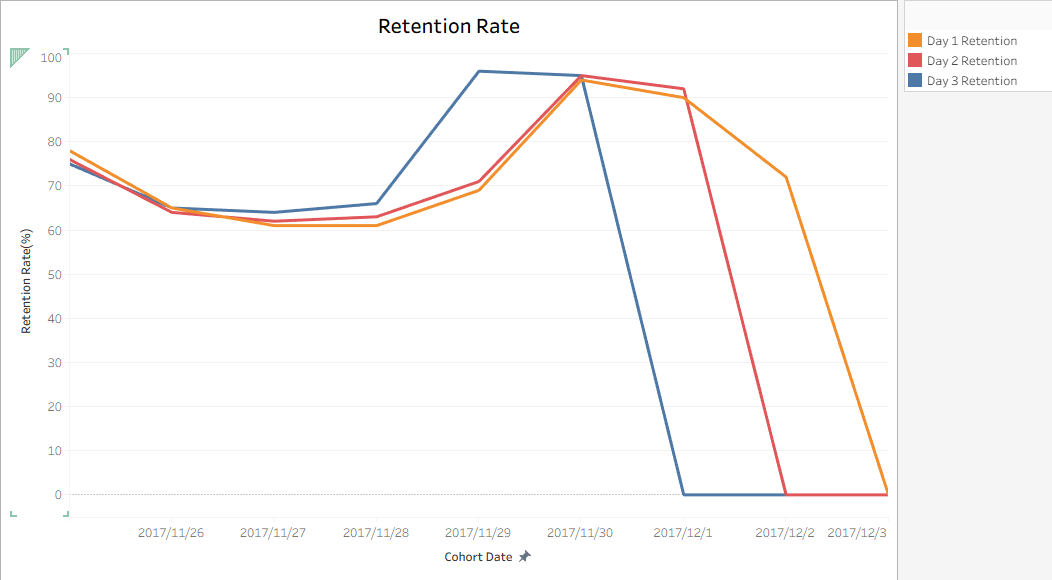

In [ ]:
display(Image(filename='Problem 1.png'))

**Conclusion:**

From the user data, the scale of new users from November 25th to 30th is relatively large, and retention is generally stable. Day 1 retention is between 61% and 78%, and Day 3 remains between 64% and 75%. This indicates high activity among new users in this phase and good platform user growth.

Entering December, the number of new users dropped sharply. Statistics show 987,399 active users in December, with old users accounting for 99.97% (987,125) and only 274 new users. This suggests December's activity comes mainly from existing users, with negligible new users. Meanwhile, retention data in early December fluctuated significantly, likely due to the small sample size and abnormal access during the "Double 12" event. Contextually, December 1-8 is the warm-up period for Taobao's "Double 12" event, where user traffic focuses on old users adding to carts and browsing, rather than new user registrations.

**Suggestions:**
1. Maintain the user acquisition strategy from late November: New users from this period are high quality. Review promotion channels and marketing content to find high-quality sources and continue or strengthen them. 
2. High traffic but low new users during Double 12 suggests the event lacks attraction for new customers. Suggest adding guidance and offers for new users in the main venue and payment pages, like "Newcomer Exclusive Red Packets" or "First Purchase Rewards". 
3. Track the activity of old users reactivated in December over January and February to evaluate the long-term value of the event and inform future strategies.


# Question 2

Behavior Conversion:<br><br>
Browsing (pv) → Favorite (fav) + Add to Cart (cart) → Purchase (buy) <br><br>
Favoriting and adding to cart do not have a direct causal relationship, so we group them together as interest behaviors.

In [ ]:
query = """WITH user_behavior_profile AS (
    SELECT 
        behavior_type,
        sum(CASE WHEN behavior_type = 'pv' THEN 1 ELSE 0 END) AS pv_count,
        sum(CASE WHEN behavior_type in ('fav', 'cart') THEN 1 ELSE 0 END) AS fav_cart_count,
        sum(CASE WHEN behavior_type = 'buy' THEN 1 ELSE 0 END) AS buy_count
    FROM user_behavior_data
)
SELECT
    pv_count, fav_cart_count, buy_count,
    round(100 * fav_cart_count/pv_count) as 'conversion between fav/cart and pv',
    round(100 * buy_count/fav_cart_count) as 'conversion between fav/cart and buy',
    round(100 * buy_count/pv_count) as 'conversion between pv and buy'
FROM user_behavior_profile
"""
conversion_funnel = pd.read_sql_query(query, conn)
conversion_funnel

,pv_count,fav_cart_count,buy_count,conversion between fav/cart and pv,conversion between fav/cart and buy,conversion between pv and buy
0,89660687,8418704,2015839,9.0,23.0,2.0


In [ ]:
conversion_funnel.to_csv('conversion_funnel_data.csv')

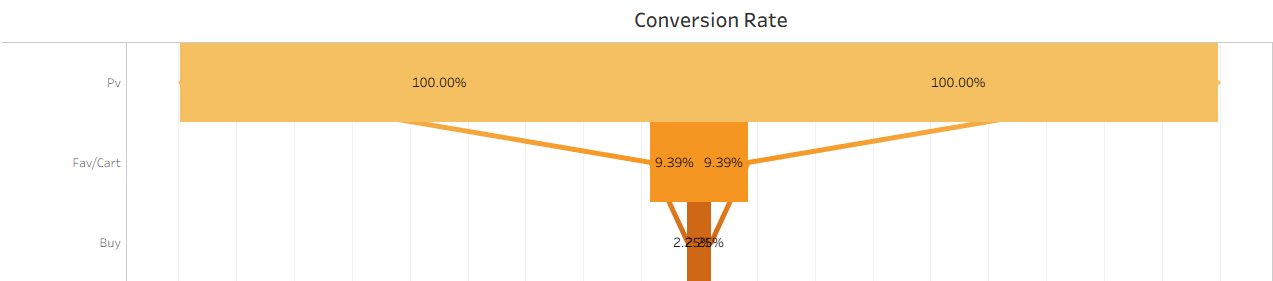

In [ ]:
display(Image(filename='problem 2.png'))

The overall conversion rate (View → Buy) is 2%, meaning that on average, every 100 views result in only 2 purchases.<br><br>
The conversion rate from interest behaviors (Favorite or Add-to-Cart) to Buy is 23%, indicating that once a user shows interest in a product, 23 out of 100 interest behaviors eventually convert to a purchase.<br><br>
However, only 9% of views convert to interest behaviors, which implies that although most users browse, they do not express further intent to buy. This might be because users compare prices after adding to the cart and find better alternatives.

**Recommendations**：
The main bottleneck in the current purchase conversion is the interest stimulation stage. If we can effectively increase the ratio of Views to Favorite/Cart, it will significantly boost the overall purchase conversion effect.
Consider optimizing product detail pages and offering store-follow coupons, etc.<br><br>
For users with items remaining in the cart for over $24 \sim 48$ hours, push personalized limited-time coupons or limited-time free shipping notifications. This aims to overcome price hesitation and encourage immediate ordering.

# Question 3：

In [ ]:
query_3 = """
SELECT
    CAST(strftime('%H', activity_time) AS INTEGER) AS hours,
    CASE
        When strftime('%w', activity_time) between '1' AND '5' THEN 'Weekday'
        ELSE 'Weekend'
    End as week_of_day,
    sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END) AS total_pv,
    sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) AS total_buy,
    round(100.0 * sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) / sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END), 2) as buy_to_pv_ratio
FROM user_behavior_data
GROUP BY hours, week_of_day
ORDER BY hours, week_of_day
"""
df = pd.read_sql_query(query_3, conn)
df

,hours,week_of_day,total_pv,total_buy,buy_to_pv_ratio
0,0,Weekday,1503565,32770,2.18
1,0,Weekend,1553371,25006,1.61
2,1,Weekday,682363,11928,1.75
3,1,Weekend,739309,11241,1.52
4,2,Weekday,377151,6182,1.64
5,2,Weekend,392118,5830,1.49
6,3,Weekday,266335,4212,1.58
7,3,Weekend,258657,3814,1.47
8,4,Weekday,233239,3579,1.53
9,4,Weekend,216389,3169,1.46


In [ ]:
df.to_csv('hourly_behavior_analysis.csv')

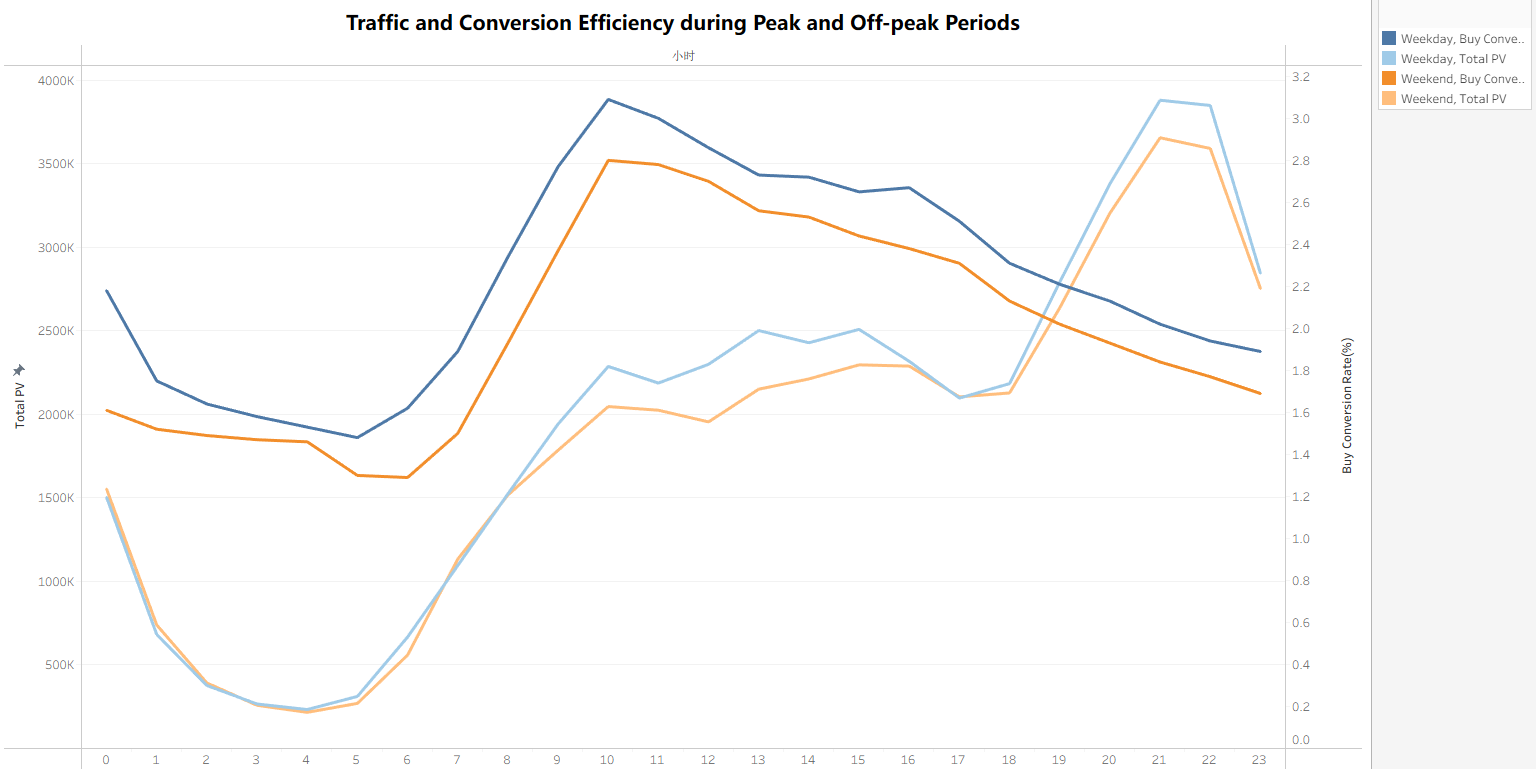

In [ ]:
display(Image(filename='Problem 3.png'))

Traffic peaks at 9 PM (21:00), consistent across both weekdays and weekends. We recommend concentrating brand promotion or high-exposure campaigns during this period.<br><br> The lowest traffic point is around 4 AM. This time is suitable for system maintenance, data backup, and deployment of non-critical functions.<br><br>

Conversion efficiency peaks at 10 AM, suggesting users during this time have the strongest intent. We recommend recommending high-value, high-margin products during this window.<br><br> Although traffic peaks at 9 PM, the conversion rate is lower, indicating weaker purchase intent. We recommend reducing campaigns that require high conversion rates during this time and focusing instead on brand exposure and guiding users to add to cart or favorite items.

# Question 4：

RFM Analysis：<br><br>
Recency (R): how recently the user performed a key action (e.g. purchase, add to cart, etc)

Frequency (F): how often the user performs a action.

Monetary (M): how much money the user spent (can be total or average spent)

In [15]:
query_RFM = """With buy_cust_data AS(
    Select user_id, max(activity_time) as lastest_purchase_date, count(*) as purchase_frequency
    From user_behavior_data
    Where behavior_type = 'buy'
    Group by user_id
), 
RFM_scores AS(     
Select 
    user_id,
    Round(julianday('2017-12-03 23:59:59') - julianday(lastest_purchase_date),2) as recency,
    purchase_frequency as frequency
From buy_cust_data
Order by recency ASC, frequency DESC
),
Ranked_RFM AS(     
Select
    user_id,
    recency,
    frequency,
    NTILE(5) OVER (ORDER BY recency DESC) as R_score,   
    NTILE(5) OVER (ORDER BY frequency ASC) as F_score 
From RFM_scores
)
Select    
    user_id,
    recency,
    frequency,
    R_score,
    F_score,
    Case
        When R_score >=4 and F_score >=4 then 'Key Value / Loyal Customers'
        When R_score >=4 and F_score between 1 and 2 then 'New / Potential Customers'
        When R_score = 3 then 'Customers Needing Attention'
        When R_score between 1 and 2 and F_score >=4 then 'Key Retention Customers'
        When R_score between 1 and 2 and F_score =3 then 'General Retention Customers'
        Else 'Low Value / Lost Customers'    -- R = 1-2 and F = 1-2
    End as user_Category
From Ranked_RFM
"""

RFM_profile = pd.read_sql_query(query_RFM, conn)
RFM_profile

,user_id,recency,frequency,R_score,F_score,user_Category
0,33413,9.0,1,1,2,Low Value / Lost Customers
1,35015,9.0,1,1,2,Low Value / Lost Customers
2,38184,9.0,1,1,2,Low Value / Lost Customers
3,40193,9.0,1,1,2,Low Value / Lost Customers
4,45489,9.0,1,1,2,Low Value / Lost Customers
...,...,...,...,...,...,...
672399,244049,0.0,32,5,5,Key Value / Loyal Customers
672400,507808,0.0,34,5,5,Key Value / Loyal Customers
672401,313229,0.0,45,5,5,Key Value / Loyal Customers
672402,907690,0.0,56,5,5,Key Value / Loyal Customers


User segmentation reference: https://www.spsspro.com/help/rfm/#_3-%E6%A0%B9%E6%8D%AE%E7%94%A8%E6%88%B7%E7%B1%BB%E5%9E%8B%E8%AE%BE%E5%AE%9A%E8%90%A5%E9%94%80%E7%AD%96%E7%95%A5

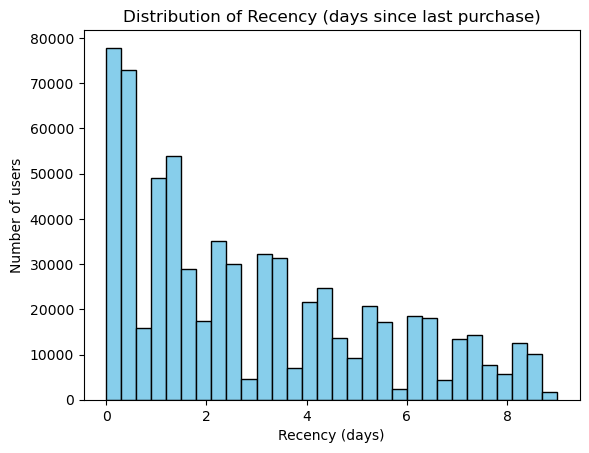

In [ ]:
plt.hist(RFM_profile['recency'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Recency (days since last purchase)')
plt.xlabel('Recency (days)')
plt.ylabel('Number of users')
plt.show()


In [ ]:
RFM_profile['recency'].describe()

count    672404.000000
mean          2.907192
std           2.433091
min           0.000000
25%           0.940000
50%           2.260000
75%           4.520000
max           9.000000
Name: recency, dtype: float64

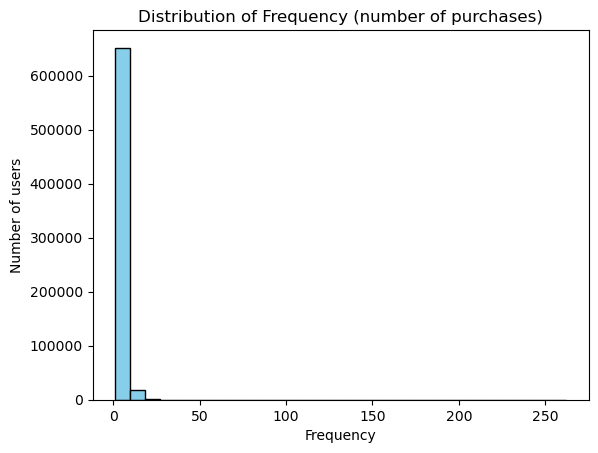

In [ ]:
plt.hist(RFM_profile['frequency'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Frequency (number of purchases)')
plt.xlabel('Frequency')
plt.ylabel('Number of users')
plt.show()


In [ ]:
RFM_profile['frequency'].describe()

count    672404.000000
mean          2.997958
std           2.894739
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         262.000000
Name: frequency, dtype: float64

75% of users have 4 or fewer purchases, indicating that the data for the majority of users is reasonable. We noticed a maximum value of 262, which is somewhat implausible for a dataset covering only a 9-day period.

In [ ]:
RFM_profile[RFM_profile['frequency'] > 100]['frequency'].value_counts()

frequency
159    1
118    1
112    1
262    1
131    1
109    1
177    1
110    1
Name: count, dtype: int64

Although these values appear unreasonable, there are not many of them, so we will retain them for now; they will not affect the scoring mechanism.

Analysis:

| User Type | User RFM Characteristics (R/F Score, 5-point scale) | Marketing Strategy |
| :--- | :--- | :--- |
| Key Value Users / Loyal Customers | R $\in \{4, 5\}$, F $\in \{3, 4, 5\}$ (High R, High F) | Extend user loyalty, provide VIP services, exclusive events, or permanent discounts to create a sense of honor. |
| New Customers / Potential Customers | R $\in \{4, 5\}$, F $\in \{1, 2\}$ (High R, Low F) | Stimulate repeat purchases, increase brand loyalty. Regularly send info on new arrivals, bestsellers, and discounts; provide beginner tutorials. |
| Customer Needing Attention | R $= 3$, F $\in \{1, 2, 3, 4, 5\}$ (Medium R) | Customers on the edge of churning, need proactive contact to prevent loss. Push promotions and personalized recommendations, or proactively care about product usage. |
| Key Retention Users | R $\in \{1, 2\}$, F $\in \{4, 5\}$ (Low R, High F) | High-value customers about to churn, need strong efforts to win back. Use phone calls, large coupons, or significant offers like "Buy One Get One Free" to reactivate. |
| General Retention Users | R $\in \{1, 2\}$, F $= 3$ (Low R, Medium F) | Customers with potential value but are churning. Attempt contact with medium cost, e.g., small targeted coupons, personalized recommendations based on history. |
| Low Value / Lost Customers | R $\in \{1, 2\}$, F $\in \{1, 2\}$ (Low R, Low F) | Users already in churn phase, skip marketing or use very low cost attempts to reach out, reducing waste of marketing resources. |

In [ ]:
RFM_profile.to_csv('RFM_user_profile.csv')

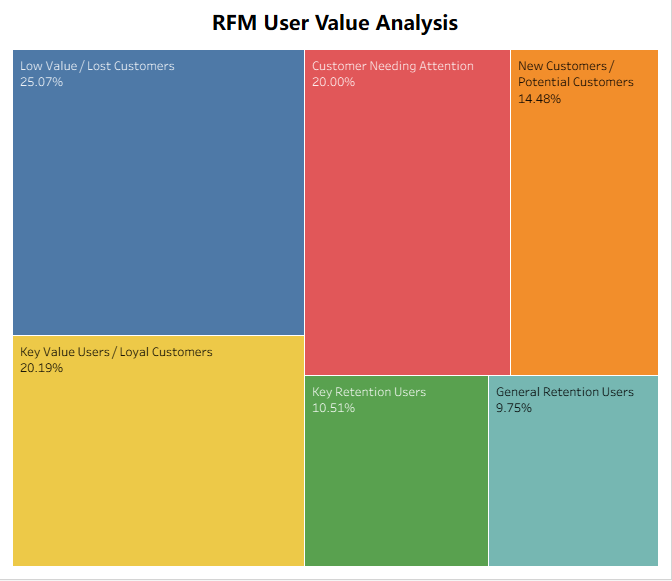

In [17]:
display(Image(filename='Problem 4.png'))

# Question 5：

In [ ]:
query_5= """
Select 
    category_id,
    sum(case when behavior_type = 'pv' THEN 1 ELSE 0 END) AS total_pv,
    count(distinct case when behavior_type = 'pv' THEN user_id END) AS total_uv,
    sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) AS total_buy,
    count(distinct case when behavior_type = 'buy' THEN user_id END) AS unique_buy,
    round(sum(case when behavior_type = 'buy' THEN 1 ELSE 0 END) * 1.0 / count(distinct case when behavior_type = 'buy' THEN user_id END), 2) as buy_freq,
    round(100.0 * count(distinct case when behavior_type = 'buy' THEN user_id END) / count(distinct case when behavior_type = 'pv' THEN user_id END), 2) as uv_to_buy_ratio
FROM user_behavior_data
group by category_id
order by total_buy DESC
"""
category_performance = pd.read_sql_query(query_5, conn)
category_performance

,category_id,total_pv,total_uv,total_buy,unique_buy,buy_freq,uv_to_buy_ratio
0,1464116,683641,170789,34591,29953,1.15,17.54
1,2735466,1115651,255222,33730,28759,1.17,11.27
2,2885642,954553,148345,31844,27118,1.17,18.28
3,4145813,3150716,368450,31658,27529,1.15,7.47
4,4756105,4477682,410410,28258,23754,1.19,5.79
...,...,...,...,...,...,...,...
9432,7031,1,1,0,0,NaN,0.00
9433,6991,132,85,0,0,NaN,0.00
9434,5260,4,3,0,0,NaN,0.00
9435,1147,1,1,0,0,NaN,0.00


Operational Recommendations:<br><br> Invest new budget primarily into categories $2885642$ and $1464116$, and use them as main drivers for new user acquisition to ensure new users have a good first purchase experience.